# Photosynthesis estimation function

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- **Light intensity & spectrum (400-700 nm)**
- Pigment concentrations: **Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin**
- Use the **measured absorption spectrum to calculate the light attenuation**
- NOT Chlorophyll concentration in sample cuvette BUT **Cell density in cells/ml**

### Output

NOT Concentrations BUT **Rates of ATP, NADPH, 3PGA, Fd_red**

## Predict the rates

In [17]:
import numpy as np
import pandas as pd
from modelbase.ode import Model, Simulator
from modelbase.ode import ratefunctions as rf

import sys
sys.path.append("../Code")
import functions_light_absorption as lip
from function_predict_simulated_ssrates import get_simulated_ssrates, get_influx_rate_estimations, get_influx_rate_estimations_modelbase
from parameters import p

In [18]:
# Get the rates under 100 µE of solar light with default model pigment content 
# and assuming we want 10% of the maximal ATP, 50% maximal NADPH, 10 maximal Fd_red and 30% maximal 3PGA production
rates = get_simulated_ssrates(
    lip.light_spectra("solar", 100),
    pigment_content=p["pigment_content"],
    rate_ratios={"ATP":0.1, "NADPH": 0.5, "Fd_red":0.1, "3PGA":0.3}
)
rates

production_rate
ATP        4.421157
NADPH     15.147810
3PGA       2.217392
Fd_red     6.002534
dtype: float64

## Interface between Andreas model and the prediction function

In [19]:
# Example output
# The rows contain the flux of a certain production reaction
# The columns are the fluxes of all metabolites determined for a model where the compound in the name was drained via a sink reaction.
# Other meatbolites were only consumed if the metabolite pool was filled to over 95% (analogous to synechocystis ETC paper)
rates = get_influx_rate_estimations(
        light_intensity=100, # Model
        rate_ratios=None,
        cell_density=1e8, # [cells ml^-1]
        chlorophyll=10000, # [µmol l^-1]
        carotenoids=3000, # [µmol l^-1]
        phycocyanin=None, # [µmol l^-1]
        allophycocyanin=None, # [µmol l^-1]
        beta_carotene_fraction=0.26, # [rel] fraction of beta-carotene of cellular carotenoids
        ps_ratio=5.9,
        sample_depth_m=0.01, # [m] Assuming a cuvette with 1 cm diameter
    )
rates

target_compound,ATP,NADPH,3PGA,Fd_red
production_rate,,,,
ATP,11.289662,-0.000842,0.000000,0.000000
NADPH,0.000000,7.561546,0.000000,0.000000
3PGA,0.838524,-0.008760,1.385843,-0.004052
Fd_red,0.000000,0.000000,0.000000,15.207014


## Mock model to add the funciton dynamically
The function calculates the steady-state input rates at every time point.
For that, I calculate the fraction of each metabolite pool the this not filled (e.g. ADP in the ATP pool).
Then I use the relative size of these "used-up" metabolite pools as the ratios that are the input to the rate estimation function.
The fractions are used to scale the maximal steady-state produciton rates for each metabolite that I simulated under the given conditions.

The pigment contents are currently assumed fixed and a few tweaks have to be made to the funcitons to make them dynamic.

In [20]:
# Create a mock model
m = Model()
# Add the compounds
m.add_compounds(["ATP", "NADPH", "3PGA", "Fd_red"])

# Add total pools or maximal concentrations
totals = {"ATP":"ATP_tot", "NADPH":"NADP_tot", "3PGA":"3PGA_max", "Fd_red":"Fd_tot"}

p = {
    "k_ATP": 5,
    "k_NADPH": 5,
    "k_3PGA": 5,
    "k_Fd_red": 5,
    "ATP_tot": 1,
    "NADP_tot": 1,
    "3PGA_max": 1,
    "Fd_tot": 1,

    "light":100, # [µmol(Photons) m^-2 s^-1] Light intensity (warm white LED) 
    "cell_density":1e8, # [cells ml^-1]
    "chlorophyll":10000, # [µmol l^-1]
    "carotenoids":3000, # [µmol l^-1]
    "phycocyanin":None, # [µmol l^-1]
    "allophycocyanin":None, # [µmol l^-1]
    "beta_carotene_fraction":0.26, # [rel] fraction of beta-carotene of cellular carotenoids
    "ps_ratio":5.9,
    "sample_depth_m":0.01, # [m] Assuming a cuvette with 1 cm diameter
    "cell_volume": 4e-15,
}
m.add_parameters(p)

def fraction(S, S_tot):
    return S/S_tot

# Add algebraic models
for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]:
    m.add_algebraic_module_from_args(
        f"{comp} fraction",
        function=fraction,
        derived_compounds=[f"{comp}_fraction"],
        args=[comp, totals[comp]]
    )

    m.add_reaction_from_args(
        f"{comp} consumption",
        function=rf.mass_action_1,
        stoichiometry={comp:-1},
        args=[f"k_{comp}", comp]
    )

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

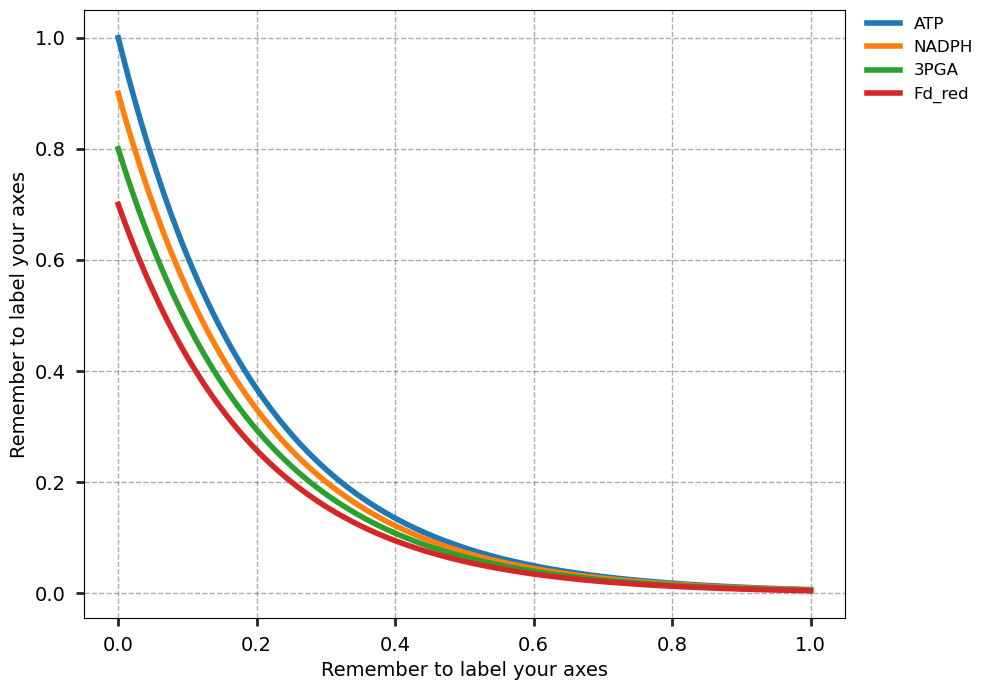

In [21]:
s=Simulator(m)
s.initialise({"ATP":1, "NADPH":0.9, "3PGA":0.8, "Fd_red":0.7})
s.simulate(1)
s.plot()

### Wrapper function

### Add production to mock model

In [22]:
# Estimate the required production ratios by the fill state of the metabolite pools
def get_required_production_ratio(*args):
    frac = np.stack(args, axis=0)
    frac = 1 - frac
    rel_frac = frac / frac.sum(axis=0)
    return rel_frac

m.add_algebraic_module_from_args(
    "production ratios",
    function=get_required_production_ratio,
    derived_compounds=[f"{comp}_prodratio" for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]],
    args=[f"{comp}_fraction" for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]]
)

m.add_algebraic_module_from_args(
    "production_rates",
    function=get_influx_rate_estimations_modelbase,
    derived_compounds=["vATP_prod", "vNADPH_prod", "v3PGA_prod", "vFd_red_prod"],
    args=[
        "light",
        "ATP_prodratio",
        "NADPH_prodratio",
        "3PGA_prodratio",
        "Fd_red_prodratio",
        "cell_density",
        "chlorophyll",
        "carotenoids",
        "phycocyanin",
        "allophycocyanin",
        "ps_ratio",
        "beta_carotene_fraction",
        "sample_depth_m",
        "cell_volume",
    ]
)

# Add algebraic models
for comp in ["ATP", "NADPH", "3PGA", "Fd_red"]:
    m.add_reaction_from_args(
        f"{comp} production",
        function=rf.constant,
        stoichiometry={comp:1},
        args=[f"v{comp}_prod"]
    )

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

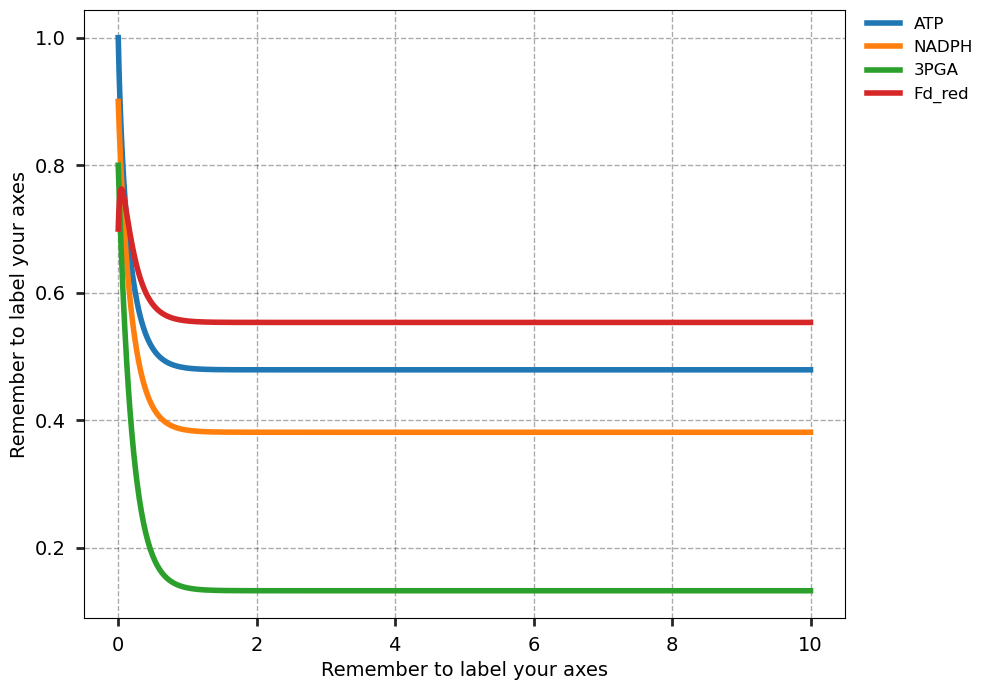

In [23]:
s=Simulator(m)
s.initialise({"ATP":1, "NADPH":0.9, "3PGA":0.8, "Fd_red":0.7})
s.simulate(10)
s.plot()

In [24]:
s.get_full_results_df()

,ATP,NADPH,3PGA,Fd_red,ATP_fraction,NADPH_fraction,3PGA_fraction,Fd_red_fraction,ATP_prodratio,NADPH_prodratio,3PGA_prodratio,Fd_red_prodratio,vATP_prod,vNADPH_prod,v3PGA_prod,vFd_red_prod
0.000000,1.000000,0.900000,0.800000,0.700000,1.000000,0.900000,0.800000,0.700000,0.000000,0.166667,0.333333,0.500000,-0.000140,1.260258,0.458462,7.603507
0.000008,0.999959,0.899973,0.799971,0.700034,0.999959,0.899973,0.799971,0.700034,0.000069,0.166694,0.333347,0.499890,0.000639,1.260462,0.458538,7.601840
0.000017,0.999917,0.899946,0.799941,0.700068,0.999917,0.899946,0.799941,0.700068,0.000138,0.166721,0.333360,0.499781,0.001417,1.260667,0.458615,7.600174
0.000039,0.999804,0.899873,0.799861,0.700161,0.999804,0.899873,0.799861,0.700161,0.000326,0.166795,0.333397,0.499482,0.003543,1.261225,0.458825,7.595627
0.000062,0.999691,0.899800,0.799781,0.700253,0.999691,0.899800,0.799781,0.700253,0.000514,0.166868,0.333434,0.499183,0.005666,1.261782,0.459034,7.591084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.806313,0.479302,0.381412,0.132989,0.553574,0.479302,0.381412,0.132989,0.553574,0.212294,0.252205,0.353489,0.182013,2.396512,1.907058,0.664946,2.767868
8.374501,0.479302,0.381412,0.132989,0.553574,0.479302,0.381412,0.132989,0.553574,0.212294,0.252205,0.353489,0.182013,2.396512,1.907058,0.664946,2.767868
8.942690,0.479302,0.381412,0.132989,0.553574,0.479302,0.381412,0.132989,0.553574,0.212294,0.252205,0.353489,0.182013,2.396512,1.907058,0.664946,2.767868
9.510879,0.479302,0.381412,0.132989,0.553574,0.479302,0.381412,0.132989,0.553574,0.212294,0.252205,0.353489,0.182013,2.396512,1.907058,0.664946,2.767868
